## Helper functions for note sequence training dataset creation

In [1]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus
from tqdm import tqdm
from music21 import corpus, metadata, note, stream

def corpus_to_training_data(composer):
    paths = corpus.getComposer(composer)

    all_states = set()
    all_pitches = set()
    all_durations = set()
    training_data = []
    chord_occurence_count = 0
    note_count = 0
    for p in tqdm(paths):
        # Load the score
        s = corpus.parse(p)
        
        soprano_part = None
        for part in s.parts:
            if "Soprano" in (part.partName or ""):  # Check for 'Soprano' in the part name
                soprano_part = part
                break
        
        # Fallback if no explicit Soprano part is named
        if soprano_part is None:
            # Assume the first part is the Soprano if no explicit naming is found
            soprano_part = s.parts[0]
        
        # Extract notes and rests (pitch and duration)
        notes_sequence = []
        for element in soprano_part.flat.notesAndRests:  # Include notes and rests
            if element.isNote:
                notes_sequence.append((element.pitch.nameWithOctave, element.quarterLength))
            elif element.isChord:        
                # If there's a chord, take the highest note (melodic line usually uses the top note)
                #notes_sequence.append((element.highestNote.nameWithOctave, element.quarterLength))
    
                # Get the bass (lowest) note of the chord
                bass_note = element.bass()
                notes_sequence.append((bass_note.nameWithOctave, element.quarterLength))
    
                chord_occurence_count += 1
            elif element.isRest:
                notes_sequence.append(('Rest', element.quarterLength))
    
        notes = []
        for pitch, duration in notes_sequence:    
            all_pitches.add(pitch)
            all_durations.add(duration)
            s = (pitch, duration)
            if pitch == 'Rest':
                notes.append(note.Rest(quarterLength=s[1]))
                #ignore rests for now
                #pass
            else:
                notes.append(note.Note(s[0], quarterLength=s[1]))        
            all_states.add(s)    
        training_data.append(notes)
        note_count += len(notes)

    print(f'note_count: {note_count}\nskipped_chord_occurence_count: {chord_occurence_count}\ntraining_data_examples: {len(training_data)}\nall_states: {len(all_states)}, all_pitches: {len(all_pitches)}')        
    return training_data, list(all_states)

## Train a model for: bach, mozart, chopin

To be replaced with data from turkish, indian, western selected music

In [2]:
bach_data, bach_states = corpus_to_training_data('bach')

/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead       | 0/433 [00:00<?, ?it/s]
  return self.iter().getElementsByClass(classFilterList)
/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead97/433 [00:01<00:10, 33.41it/s]
  return self.iter().getElementsByClass(classFilterList)
/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead11/433 [00:02<00:07, 40.56it/s]
  return self.iter().getElementsByClass(classFilterList)
/Users/kdr/.pyenv/versions/3.12.8/envs/default/lib/python3.12/site-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead32/433 [00:02<00:07, 39.3

note_count: 23338
skipped_chord_occurence_count: 1156
training_data_examples: 433
all_states: 212, all_pitches: 41


In [3]:
mozart_data, mozart_states = corpus_to_training_data('mozart')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.24it/s]

note_count: 7845
skipped_chord_occurence_count: 64
training_data_examples: 16
all_states: 394, all_pitches: 56


In [4]:
chopin_data, chopin_states = corpus_to_training_data('chopin')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.28it/s]

note_count: 340
skipped_chord_occurence_count: 13
training_data_examples: 1
all_states: 70, all_pitches: 26


In [5]:
state_union = set()
state_union.update(bach_states)
state_union.update(mozart_states)
state_union.update(chopin_states)

len(state_union)

461

## Sanity Check: Train mozart, bach, chopin

In [6]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

bach_model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(state_union))
bach_model.train(bach_data)

CPU times: user 32 ms, sys: 1.01 ms, total: 33 ms
Wall time: 33.1 ms


In [7]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

mozart_model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(state_union))
mozart_model.train(mozart_data)

CPU times: user 11.4 ms, sys: 901 μs, total: 12.3 ms
Wall time: 11.5 ms


In [8]:
%%time
from simplemelodygen.extensions import MultiInstanceTrainableMarkovChainMelodyGenerator

chopin_model = MultiInstanceTrainableMarkovChainMelodyGenerator(list(state_union))
chopin_model.train(chopin_data)

CPU times: user 1.22 ms, sys: 636 μs, total: 1.86 ms
Wall time: 1.31 ms


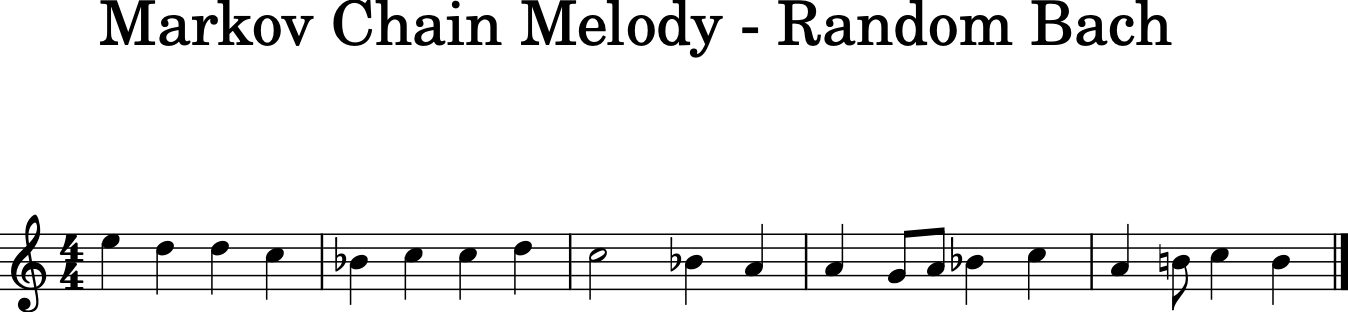

In [9]:
generated_melody, _ = bach_model.generate(20)

from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Random Bach")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

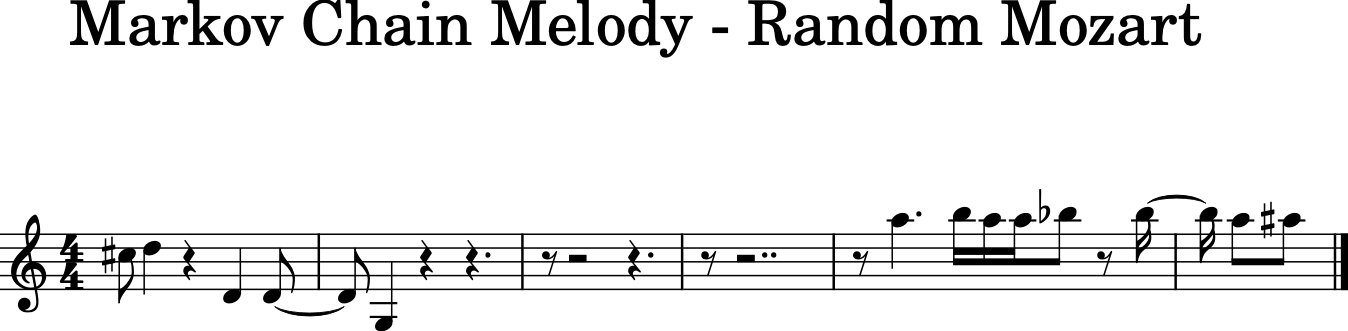

In [10]:
generated_melody, _ = mozart_model.generate(20)

from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Random Mozart")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

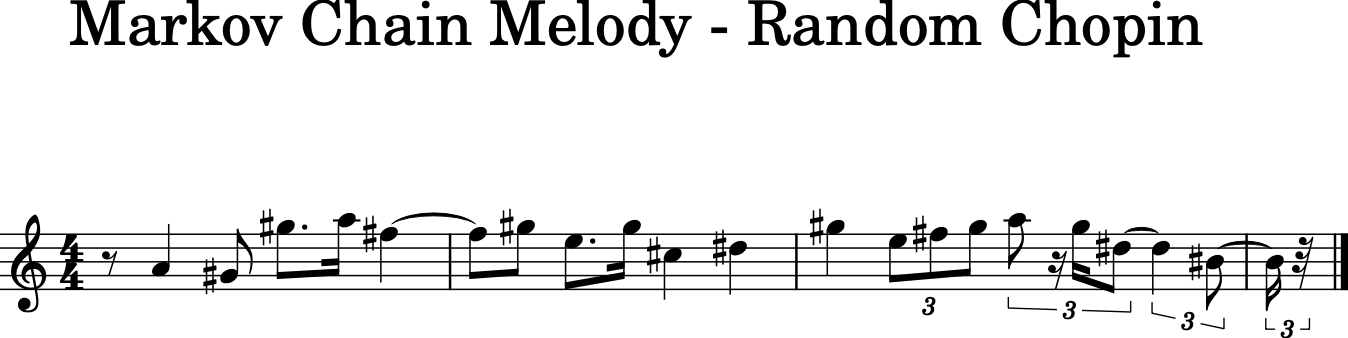

In [11]:
generated_melody, _ = chopin_model.generate(20)

from music21 import metadata, note, stream

score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody - Random Chopin")
part = stream.Part()
for n, d in generated_melody:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

score.show('midi')
score.show()

## POC chaining decisions after user input

In [12]:
def show_score(melody, title='Markov Chain Melody'):
    score = stream.Score()
    score.metadata = metadata.Metadata(title=title)
    part = stream.Part()
    for n, d in melody:
        if n == 'Rest':
            part.append(note.Rest(quarterLength=d))    
        else:
            part.append(note.Note(n, quarterLength=d))
    score.append(part)
    
    score.show('midi')
    score.show()

### Extend twinkle twinkle...

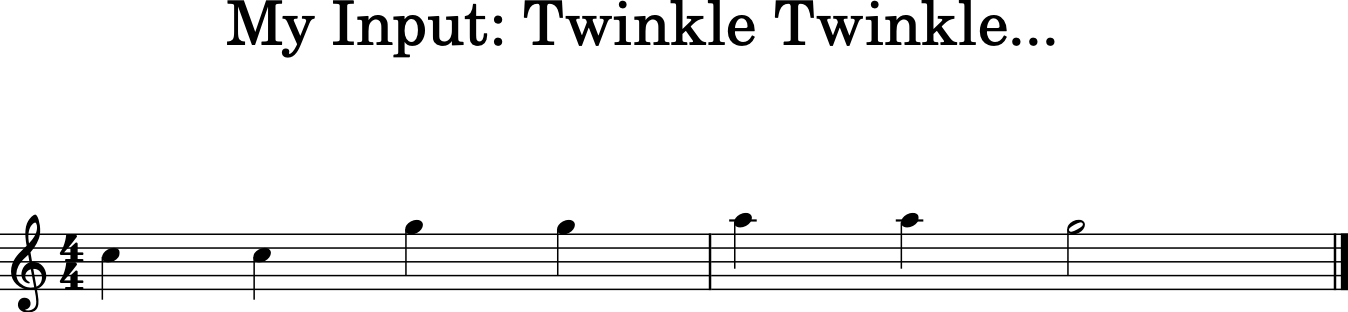

In [13]:
input_melody = [("C5", 1.0), ("C5", 1.0), ("G5", 1.0), ("G5", 1.0), ("A5", 1.0), ("A5", 1.0), ("G5", 2.0)]

show_score(input_melody, 'My Input: Twinkle Twinkle...')

### Example choices between composer based model output

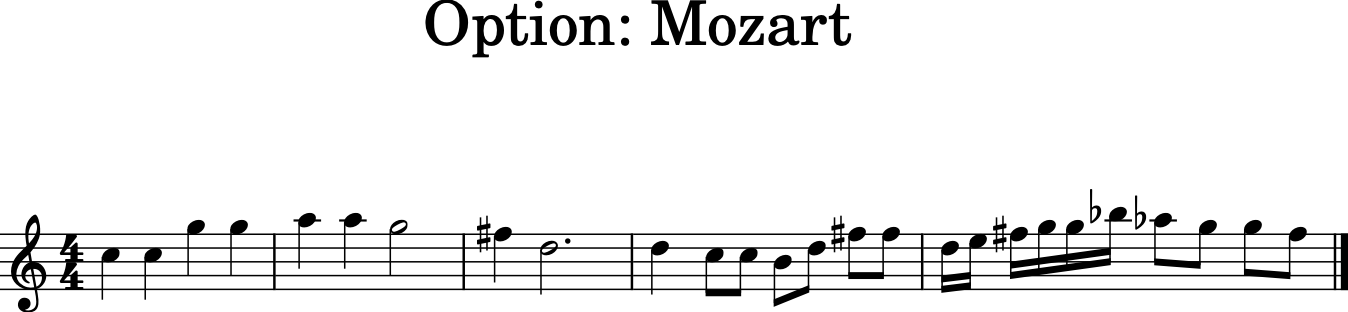

In [14]:
mozart_melody, new_part = mozart_model.generate(20, previous_sequence=input_melody)

show_score(mozart_melody, 'Option: Mozart')

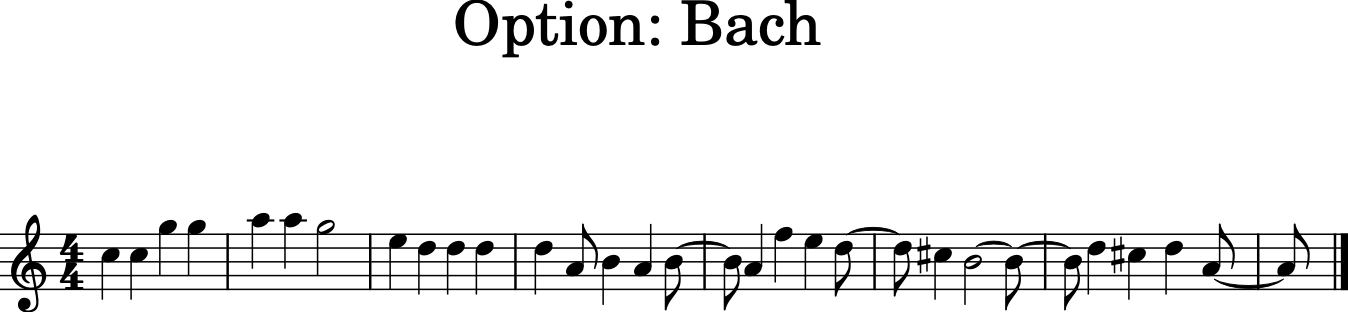

In [15]:
bach_melody, bach_new_part = bach_model.generate(20, previous_sequence=input_melody)

show_score(bach_melody, 'Option: Bach')

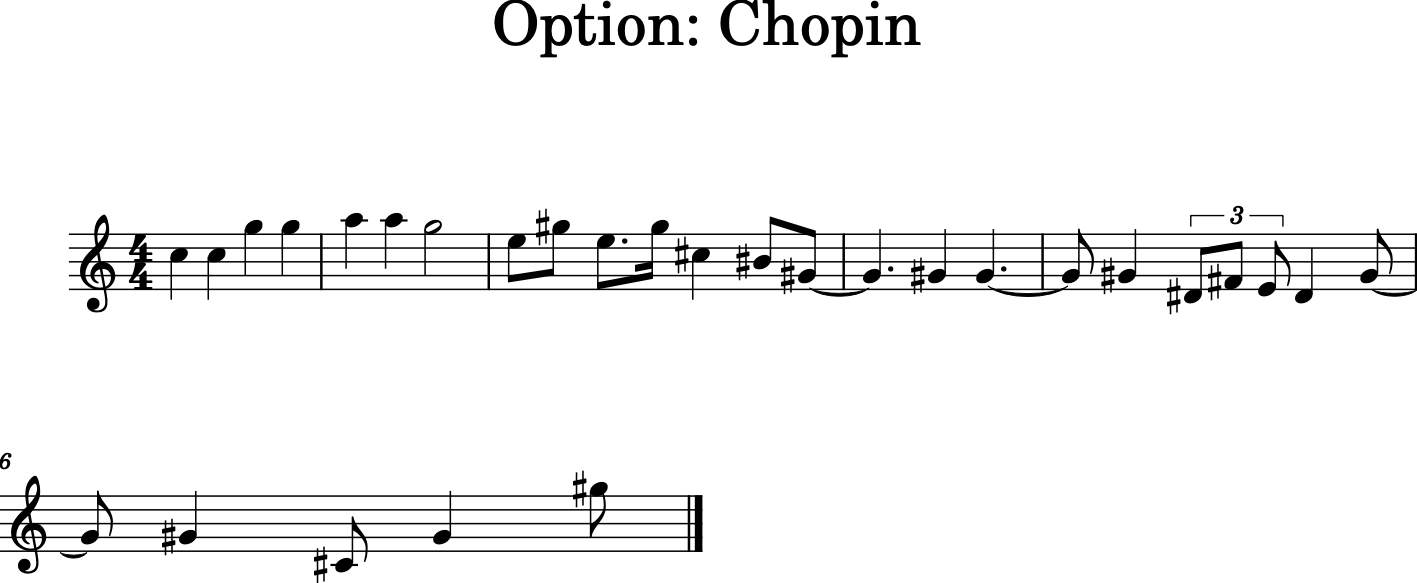

In [16]:
chopin_melody, new_part = chopin_model.generate(20, previous_sequence=input_melody)

show_score(chopin_melody, 'Option: Chopin')

In [17]:
from music21 import stream, note, chord, midi

def save_melody_to_midi(s, midi_filename):
    mf = midi.translate.music21ObjectToMidiFile(s)
    mf.open(midi_filename, 'wb')
    mf.write()
    mf.close()

score = stream.Score()
score.metadata = metadata.Metadata()
part = stream.Part()
for n, d in new_part:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

save_melody_to_midi(score, 'twinkle_and_bach.mid')

### Continue again , assume picked  bach first

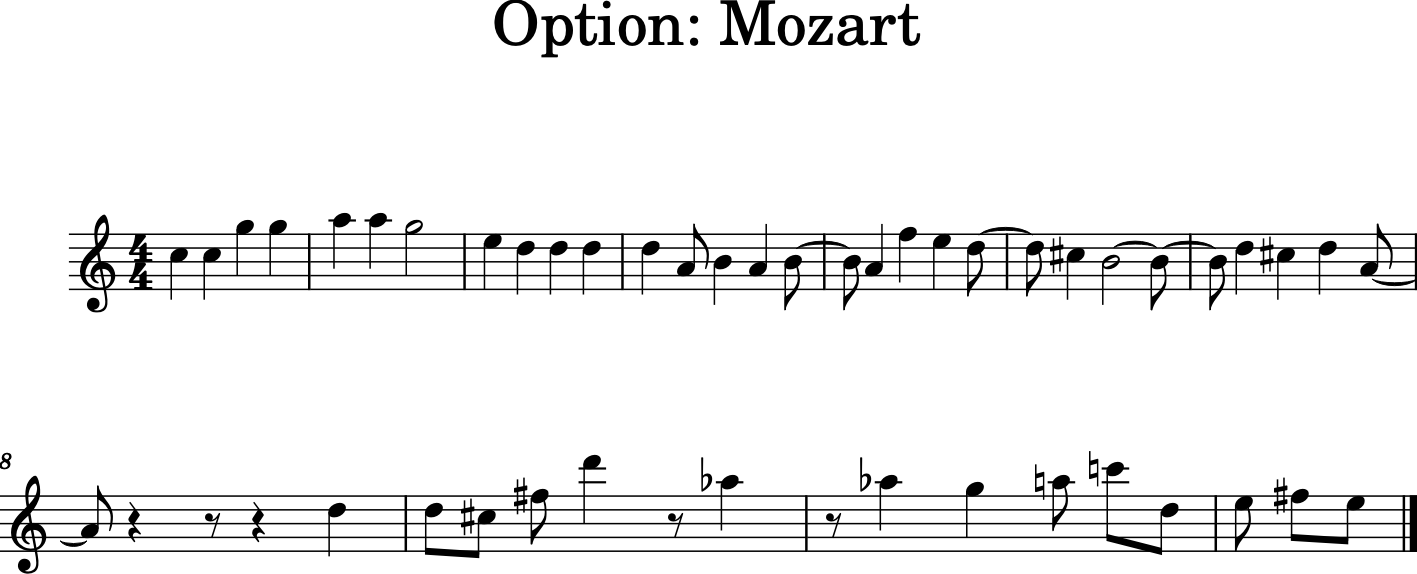

In [18]:
mozart_melody2, new_part = mozart_model.generate(20, previous_sequence=bach_melody)

show_score(mozart_melody2, 'Option: Mozart')

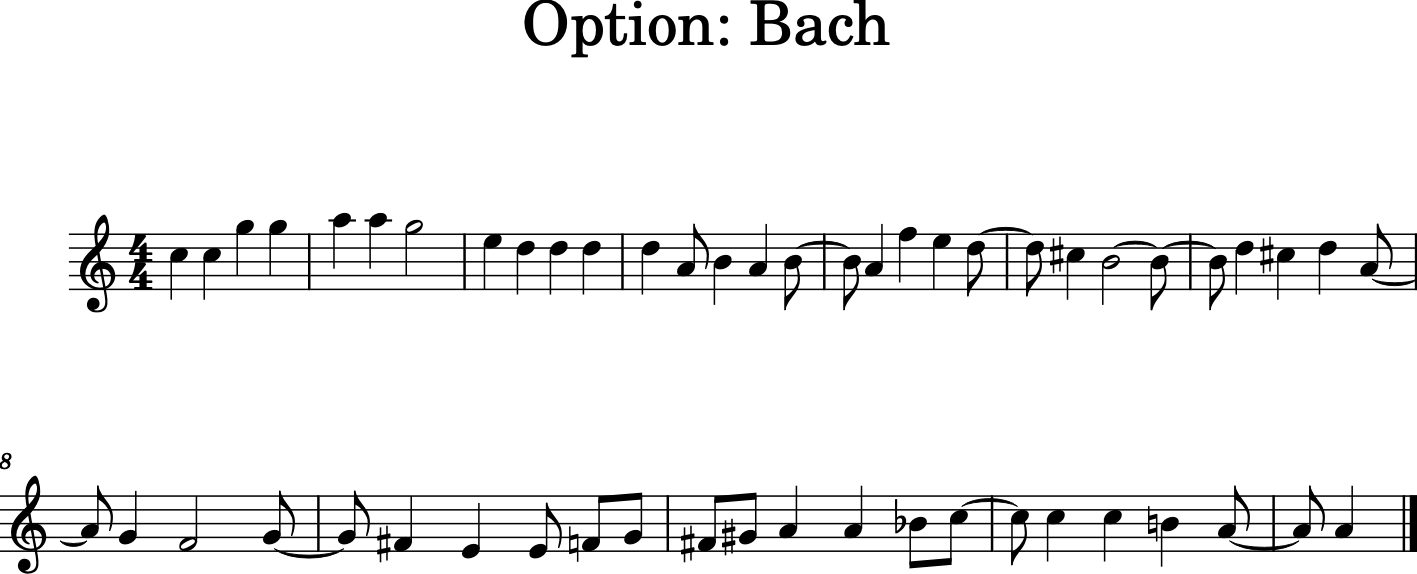

In [19]:
bach_melody2, new_part = bach_model.generate(20, previous_sequence=bach_melody)

show_score(bach_melody2, 'Option: Bach')

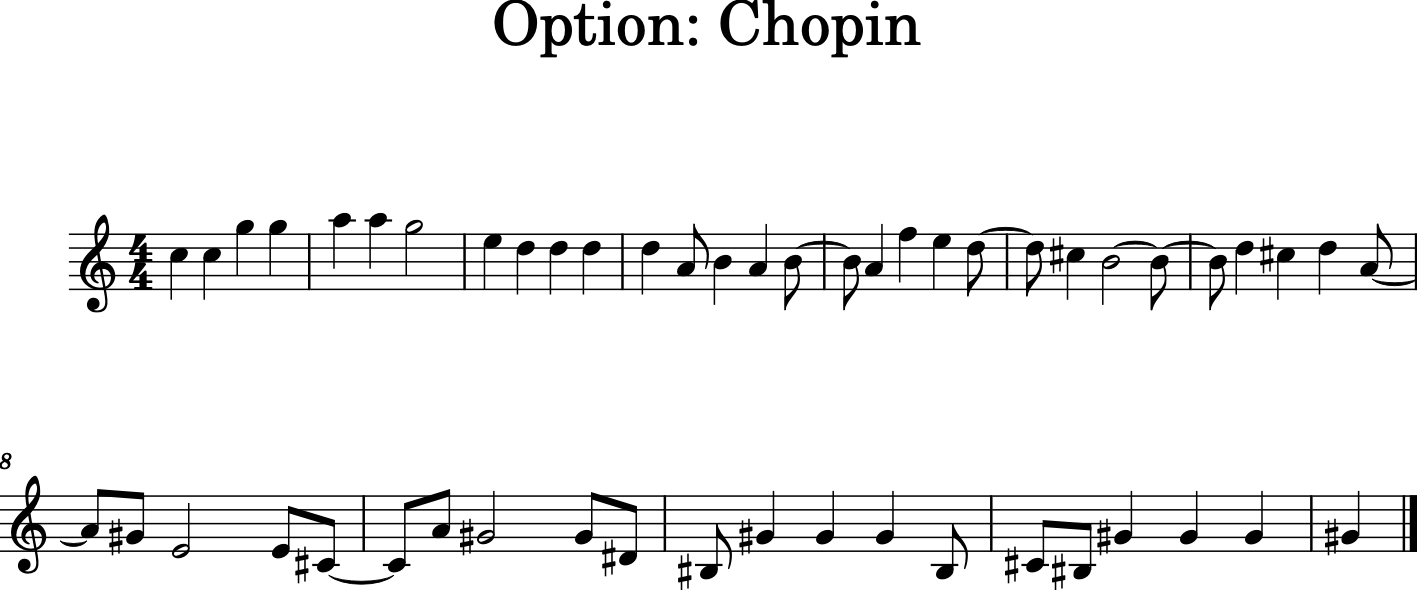

In [20]:
chopin_melody2, new_part = chopin_model.generate(20, previous_sequence=bach_melody)

show_score(chopin_melody2, 'Option: Chopin')

## Example Download

In [21]:
from music21 import stream, note, chord, midi

score = stream.Score()
score.metadata = metadata.Metadata()
part = stream.Part()
for n, d in chopin_melody2:
    if n == 'Rest':
        part.append(note.Rest(quarterLength=d))    
    else:
        part.append(note.Note(n, quarterLength=d))
score.append(part)

save_melody_to_midi(score, 'example1.mid')

## Example Midi to note sequence

In [23]:
from music21 import corpus, metadata, note, stream, converter
s = converter.parse('bach_extension.mid')

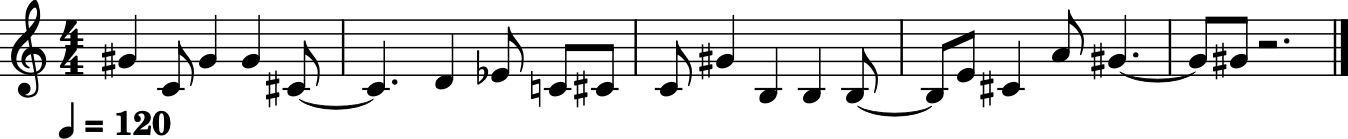

In [24]:
s.show()

In [25]:
s.show('midi')

In [30]:
def midiToMelodyNoteSequence(midiPath):
    # Load the score
    s = converter.parse(midiPath)

    # Whatever defaulting path for voice to pick otherwise part 0
    soprano_part = None
    for part in s.parts:
        if "Soprano" in (part.partName or ""):  # Check for 'Soprano' in the part name
            soprano_part = part
            break
    
    # Fallback if no explicit Soprano part is named
    if soprano_part is None:
        # Assume the first part is the Soprano if no explicit naming is found
        soprano_part = s.parts[0]
    
    # Extract notes and rests (pitch and duration)
    notes_sequence = []
    for element in soprano_part.flat.notesAndRests:  # Include notes and rests
        if element.isNote:
            notes_sequence.append((element.pitch.nameWithOctave, element.quarterLength))
        elif element.isChord:        
            # If there's a chord, take the highest note (melodic line usually uses the top note)
            #notes_sequence.append((element.highestNote.nameWithOctave, element.quarterLength))

            # Get the bass (lowest) note of the chord
            bass_note = element.bass()
            notes_sequence.append((bass_note.nameWithOctave, element.quarterLength))
        elif element.isRest:
            notes_sequence.append(('Rest', element.quarterLength))

    notes = []
    for pitch, duration in notes_sequence:    
        s = (pitch, duration)
        if pitch == 'Rest':
            notes.append(note.Rest(quarterLength=s[1]))
        else:
            notes.append(note.Note(s[0], quarterLength=s[1]))        
    return notes

In [39]:
notes = midiToMelodyNoteSequence('bach_extension.mid')

In [40]:
notes

[<music21.note.Note G#>,
 <music21.note.Note C>,
 <music21.note.Note G#>,
 <music21.note.Note G#>,
 <music21.note.Note C#>,
 <music21.note.Note C#>,
 <music21.note.Note D>,
 <music21.note.Note E->,
 <music21.note.Note C>,
 <music21.note.Note C#>,
 <music21.note.Note C>,
 <music21.note.Note G#>,
 <music21.note.Note B>,
 <music21.note.Note B>,
 <music21.note.Note B>,
 <music21.note.Note B>,
 <music21.note.Note E>,
 <music21.note.Note C#>,
 <music21.note.Note A>,
 <music21.note.Note G#>,
 <music21.note.Note G#>,
 <music21.note.Note G#>,
 <music21.note.Rest dotted-half>]

In [35]:
def note_to_state(note):    
    if note.isRest:
        state = ('Rest', note.duration.quarterLength)
    else:
        state = (note.pitch.nameWithOctave, note.duration.quarterLength)
    return state

def midiToMelodyMarkovChainNoteStates(midiPath):
    noteSequence = midiToMelodyNoteSequence(midiPath)
    return [note_to_state(note) for note in noteSequence]

In [41]:
midiToMelodyMarkovChainNoteStates('../input-experiments/twinkle.mid')

[('C5', 1.0),
 ('C5', 1.0),
 ('G5', 1.0),
 ('G5', 1.0),
 ('A5', 1.0),
 ('A5', 1.0),
 ('G5', 2.0)]